In [1]:
# ori_img2ori_img for later lidar reconstruction


from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from sensorFusionDataset.creatDataset import CreateDatasets
from sensorFusionDataset.data_split import split_dataset
from sensorFusionNetwork.simpleAutoencoder_compress import SimpleAutoencoder
from testLoop import test_loop
from trainLoop import train_loop
from visualization import plot_losses, plot_metrics,plotTraining
from earlystopping import EarlyStopping

import h5py as h5
from datetime import datetime
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import time

# local_time =time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())[-8:-1]
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
# CPU OR GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_path = 'image_gray_200_original'

img_list = sorted(glob.glob(img_path + '/*'))[0:7200]
lidar_list = sorted(glob.glob(img_path + '/*'))[0:7200]
print(len(img_list))

batch_size = 32
learning_rate = 1e-4
epochs = 300

MyDataset = CreateDatasets(img_list, lidar_list)
train_dataset, test_dataset, val_dataset = split_dataset(MyDataset, 0.7, 0.2)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
                          drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
                         drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
                        drop_last=True)

patience = 50	# 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
save_path = 'model_save/'
early_stopping = EarlyStopping(save_path = save_path, patience = patience)	

new_model = SimpleAutoencoder()
new_model.to(device)
new_model.load_state_dict(torch.load('model_save/fusion_5/compressed_encoder/ori2ori_1.pth'))

# fix the decoder
for name, value in new_model.named_parameters():
    #print (name) # print(model.state_dict().keys())
    if name.startswith('decoder'):
        value.requires_grad = False

params = filter(lambda p: p.requires_grad, new_model.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

# learning_rate = 0.0004  # 2e-4 batchsize=30
# optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

criterion = nn.MSELoss()
criterion.to(device)

training_loss = []
training_baseloss = []
test_loss = []
testing_baseloss = []
hisLrC = []
min_loss=10000

Nr = '11'

print (f'loading fertig! {device}' )

7200
loading fertig! cuda


In [ ]:
start_time = time.time()
for epoch in range(1, epochs + 1):
    # monitor training loss
    ##############################
    # start training the model #
    ##############################
    hisLrC.append(epoch)
    train_epoch_loss, train_epoch_baseloss = train_loop(train_loader, new_model, criterion, optimizer, device)
    training_loss.append(train_epoch_loss)
    # training_baseloss.append(train_epoch_baseloss)
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \t{:.0f}s'.format(epoch, epochs, train_epoch_loss,
                                                                  time.time() - start_time))

    ##############################
    # start testing the model #
    ##############################
    with torch.no_grad():
        test_epoch_loss, test_epoch_baseloss = test_loop(test_loader, new_model, criterion, device)
        test_loss.append(test_epoch_loss)
        # testing_baseloss.append(test_epoch_baseloss)
        
    # type(train_epoch_loss)) ---> float
    # writer.add_scalars('loss', {'training loss': train_epoch_loss, 'test loss': test_epoch_loss}, epoch)

        
    if test_epoch_loss < min_loss:
        min_loss = test_epoch_loss
        best_model_wts = copy.deepcopy(new_model.state_dict())
       

    if epoch == epochs:
        torch.save(best_model_wts, 'model_save/fusion_5/compressed_encoder/ori2ori_{}.pth'.format(Nr))
        print('best_testloss:{:.3f}\t epoch:{}'.format(min_loss, test_loss.index(min_loss)))     

    # 早停止
    date = dt_string
    early_stopping(test_epoch_loss, new_model, date)
    #达到早停止条件时，early_stop会被置为True
    if early_stopping.early_stop:
        torch.save(best_model_wts, 'model_save/fusion_5/compressed_encoder/ori2ori_{}.pth'.format(Nr))
        print('best_testloss:{:.3f}\t epoch:{}'.format(min_loss, test_loss.index(min_loss)))  
        print("Early stopping")
        break #跳出迭代，结束训练    
    
# train_baseline = sum(training_baseloss)/len(training_baseloss)
# test_baseline = sum(testing_baseloss)/len(training_baseloss)
# psnr_baseline = np.mean(psnr_base_list)

# train_baseline=train_baseline.item()
# test_baseline =test_baseline.item()
last_trainingloss = training_loss[-1]
last_testloss = test_loss[-1]


# write the dataset in one existed h5-file
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")

lossTrainArr = np.array(training_loss)
lossTestArr = np.array(test_loss)
bestLoss = np.array([min_loss])
LrCArr = np.array(hisLrC)

h5f =h5.File(f"log/recording_{dt_string}.hdf5","w")
# h5f = h5.File('train/train.h5', 'r+') # write in an exsited h5 file
g1 = h5f.create_group('log1')
g1.attrs['data']=now.strftime("%Y-%m-%d")
# g1.attrs['model']=ModelWts
# g1.attrs['optLrOrg']=str(optLrOrg)+'={:3.1e}'.format(optLrOrg) 
# g1.attrs['lrAdstep']= str(lrAdstep)
# g1.attrs['optimizer']= str(optimizer)[:4]

g1.create_dataset('lossTrain', data=lossTrainArr)
g1.create_dataset('lossTest', data=lossTestArr)
g1.create_dataset('bestLoss', data=bestLoss)
g1.create_dataset('LrCArr', data=LrCArr)
h5f.close()






Epoch: 1/300 	Training Loss: 0.061066 	69s
Epoch: 2/300 	Training Loss: 0.060850 	142s
Epoch: 3/300 	Training Loss: 0.060865 	195s


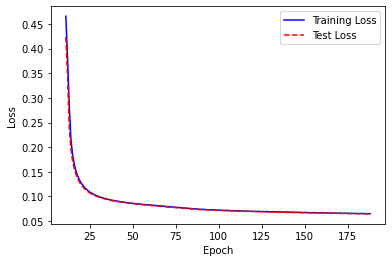

In [3]:
zoomin = 10
zoomout = 188
plotTraining(lossTrainArr, lossTestArr, LrCArr, bestLoss, zoomin, zoomout)

In [4]:
dataset_path = 'testdataset/damaged_image'
noi_img_list = sorted(glob.glob(dataset_path + '/*'))
ori_img_path = 'testdataset/ori_image'
img_list = sorted(glob.glob(ori_img_path + '/*'))

batch_size = 32

TestDataset = CreateDatasets(img_list, noi_img_list)
new_testloader = DataLoader(dataset=TestDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

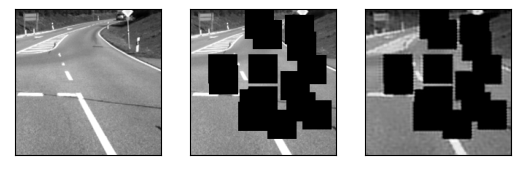

In [5]:
from torchvision import transforms

##################################################
# visualize one batch of the validation images #
##################################################
# load the best/last model
# test_model_last = SimpleAutoencoder()
test_model_best = SimpleAutoencoder()
# test_model_last.load_state_dict(torch.load('model_save/damage_{}/last_model_{}.pth'.format(damage_label, experimentIndex)))
test_model_best.load_state_dict(
    # torch.load('model_save/damage_{}/best_model_{}_{}_{}.pth'.format(damage_label, epochs, batch_size,learning_rate))
    torch.load('model_save/fusion_5/compressed_encoder/ori2ori_1.pth')
    # torch.load('denoising_model/best_model_300_32_0.0004_20230424_144726.pth')
)

# test_model.to(device)
# test_model_last.eval()
test_model_best.eval()
# obtain one batch of test images
dataiter = iter(new_testloader)
ori_img, noi_img = next(dataiter)


# get sample outputs
# output = test_model_last(noi_img)
output = test_model_best(noi_img)


# prep images for display
i =1

img1 = ori_img[i].numpy()
img1 = img1.transpose(1, 2, 0)
img2 = noi_img[i].numpy()
img2 = img2.transpose(1, 2, 0)
img3 = output[i].detach().numpy()
img3 = img3.transpose(1, 2, 0)


ax = plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
# ax.set_title('original image')
plt.imshow(img1,cmap='gray')

ax = plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
# ax.set_title('noisy image')
plt.imshow(img2,cmap='gray')

ax = plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
# ax.set_title('denoised image')
plt.imshow(img3,cmap='gray')

    # plt.savefig('fig_save/denoising_{}.png'.format(i))
plt.show()

In [7]:
removal_layer = nn.Sequential()

encoder_img = SimpleAutoencoder()
encoder_img.load_state_dict(torch.load('model_save/fusion_5/compressed_encoder/ori2ori_1.pth'))
encoder_img.decoder = removal_layer

hidden = encoder_img(noi_img)
print(hidden.shape)

torch.Size([32, 3, 50, 50])


In [ ]:

##################################################
# evaluate one batch of the validation images #
##################################################
# load the best/last model
# test_model_last = SimpleAutoencoder()
test_model_best = SimpleAutoencoder()
# test_model_last.load_state_dict(torch.load('model_save/damage_{}/last_model_{}.pth'.format(damage_label, experimentIndex)))
test_model_best.load_state_dict(
    # torch.load('model_save/damage_{}/best_model_{}_{}_{}.pth'.format(damage_label, epochs, batch_size,learning_rate))
    torch.load('Experiment2_sequence_inverse/img2img_model/best_model_300_32_0.0004_20230422_153250.pth')
    # torch.load('denoising_model/best_model_300_32_0.0004_20230424_144726.pth')
)

# test_model.to(device)
# test_model_last.eval()
test_model_best.eval()
# obtain one batch of test images
dataiter = iter(val_loader)
ori_img, noi_img = next(dataiter)

# get sample outputs
# output = test_model_last(noi_img)
output = test_model_best(noi_img)




In [ ]:
# mse
for i in range (32):
    img1 = ori_img[i]
    img3 = output[i]
    mse = criterion(img1,img3)*1000
    mse = '%.5f'%mse
    print (f' {mse}')

In [ ]:
import cv2
from PIL import Image
from torchvision import transforms

##################################################
# visualize one batch of the validation images #
##################################################
# load the best/last model
# test_model_last = SimpleAutoencoder()
test_model_best = SimpleAutoencoder()
# test_model_last.load_state_dict(torch.load('model_save/damage_{}/last_model_{}.pth'.format(damage_label, experimentIndex)))
test_model_best.load_state_dict(
    # torch.load('model_save/damage_{}/best_model_{}_{}_{}.pth'.format(damage_label, epochs, batch_size,learning_rate))
    torch.load('Experiment2_sequence_inverse/img2img_model/best_model_300_32_0.0004_20230422_153250.pth')
    # torch.load('denoising_model/best_model_300_32_0.0004_20230424_144726.pth')
)

# test_model.to(device)
# test_model_last.eval()
test_model_best.eval()
# obtain one batch of validation images
# for batch_index, dataiter in enumerate (val_loader)
dataiter = iter(val_loader)
# print (type(next(dataiter)))
ori_img, noi_img = next(dataiter)

# get sample outputs
# output = test_model_last(noi_img)
output = test_model_best(noi_img)


toPIL = transforms.ToPILImage()

# print(output.shape)
# prep images for display
for i in range(32):
    img1 = ori_img[i]
    img3 = output[i]
    # print(img1.shape, img3.shape)
    # print(type(img1),type(img3))

    im3 = toPIL(img3)
    name = '%02d' %i
    # cv2.imwrite('validation_ori_img/{}.png'.format(name), img1)

    im3.save('denoised_img/denoised_{}.png'.format(name))
